In this notebook, I explore different approaches to solving ordinary differential equations (ODEs): analytical methods, numerical methods, traditional neural networks, and PINNs. The goal is to compare how each method incorporates physical knowledge of the problem, handles extrapolation, and enables the discovery of unknown parameters.

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from scipy.integrate import solve_ivp
from tensorflow.keras import layers, models

The code above creates a time interval and a set of evaluation points that the ODE solver will use to calculate the temperature numerically. It also computes the analytical solution for comparison, and both results are plotted to visualize and compare the trends from the numerical and analytical methods.

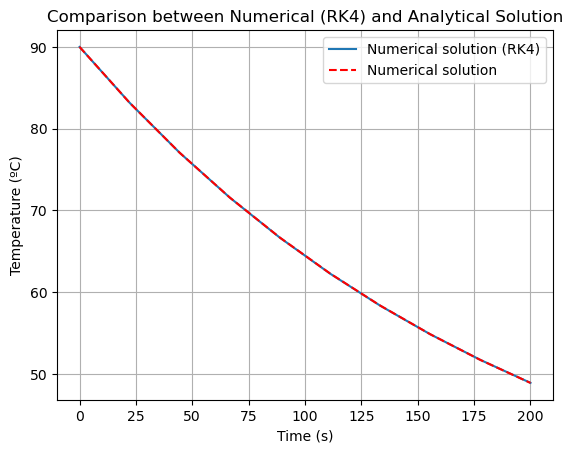

In [8]:
# Defining the ODE: dT/dt = r * (T_amb - T)
def cooling(t, T, r=0.005, T_amb=25):
    return r * (T_amb - T)

# Initial condition and time
T0 = 90
t_interval = (0, 200)  # Time interval
t_eval = np.linspace(0, 200, 10)  # Evaluation points

# Solving the ODE with the Runge-Kutta solver
solution = solve_ivp(cooling, t_interval, [T0], t_eval=t_eval)

plt.plot(solution.t, solution.y[0], label="Numerical solution (RK4)")

# Analytical solution
T_analyt = 25 + (T0 - 25) * np.exp(-0.005 * solution.t)
plt.plot(solution.t, T_analyt, '--', label="Numerical solution", color='red')

plt.xlabel("Time (s)")
plt.ylabel("Temperature (ºC)")
plt.legend()
plt.title("Comparison between Numerical (RK4) and Analytical Solution")
plt.grid(True)
plt.show()



The neural network model is designed to learn the temperature function $T(t)$. The code above generates points representing the time input, calculates the temperature for each point and its gradient. After the ODE is calculated, the MSE is generated. For this case, the cooling rate ($r$) is given as $R$.

In [10]:
def grad(outputs, inputs):
    """Computes the partial derivative of an output with respect to an input."""
    with tf.GradientTape() as tape:
        tape.watch(inputs)
        grads = tape.gradient(outputs, inputs)
    return grads

def physics_loss(model, R, Tenv):
    """The physics loss of the model."""
    # Create collocation points
    time = tf.linspace(0, 1000, num=1000)[:, tf.newaxis]  
    time = tf.Variable(time, trainable=True)  

    # Run the collocation points through the network
    temperature = model(time)

    # Get the gradient
    with tf.GradientTape() as tape:
        tape.watch(time)
        dT = tape.gradient(temperature, time)

    # Compute the ODE
    ode = dT - R * (Tenv - temperature)

    # MSE of ODE
    return tf.reduce_mean(tf.square(ode))

In this approach, the cooling rate $r$ is treated as an unknown parameter that the network will attempt to discover during training. The physical loss is computed by generating a set of time points, predicting the corresponding temperatures, and then calculating the gradient of temperature with respect to time.

In [11]:
class Net(tf.keras.Model):
    def __init__(self, *args, **kwargs):
        super(Net, self).__init__(*args, **kwargs)
        # Make r a trainable variable
        self.r = tf.Variable(0.0, trainable=True, dtype=tf.float32)

    def call(self, inputs):
        # Define the forward pass (to be implemented based on your architecture)
        pass

def physics_loss_discovery(model, Tenv):
    """Physics loss for discovering the parameter r."""
    # Create collocation points
    time = tf.linspace(0, 1000, num=1000)[:, tf.newaxis]  
    time = tf.Variable(time, trainable=True)  

    # Run the collocation points through the network
    temperature = model(time)

    # Compute the gradient of temps with respect to ts
    with tf.GradientTape() as tape:
        tape.watch(time)
        dT = tape.gradient(temperature, time)

    # Use the differentiable parameter r
    residue_ode = model.r * (Tenv - temperature) - dT

    # Return the mean squared error of the PDE residual
    return tf.reduce_mean(tf.square(residue_ode))

Generating synthetic data with noise:

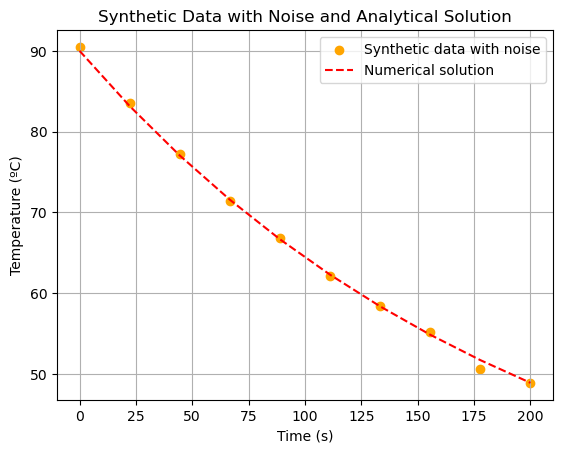

In [12]:
synthetic_data = T_analyt + np.random.normal(0, 0.5, size=len(solution.t))

plt.scatter(solution.t, synthetic_data, label="Synthetic data with noise", color='orange')
plt.plot(solution.t, T_analyt, '--', label="Numerical solution", color='red')

plt.xlabel("Time (s)")
plt.ylabel("Temperature (ºC)")
plt.legend()
plt.title("Synthetic Data with Noise and Analytical Solution")
plt.grid(True)
plt.show()

With TensorFlow, it was possible to create a neural network using the analytical solution and the synthetic data as the training set. For the model, I used 4 layers with the ReLU activation function. The model was compiled with a learning rate of 0.007 and trained for 800 epochs.

Epoch 1/800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 9764.2646
Epoch 2/800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 9176.7051
Epoch 3/800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 8708.6973
Epoch 4/800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - loss: 8292.0957
Epoch 5/800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 7907.4111
Epoch 6/800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 7554.2759
Epoch 7/800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 7231.1436
Epoch 8/800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 6936.0205
Epoch 9/800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 6666.7354
Epoch 10/800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 6421.0713
Epoch 11/800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 6196.8384
Epoch 12/800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 5991.9155
Epoch 13/800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 5804.2793
Epoch 14/800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 5632.0142
Epoch 15/800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75m

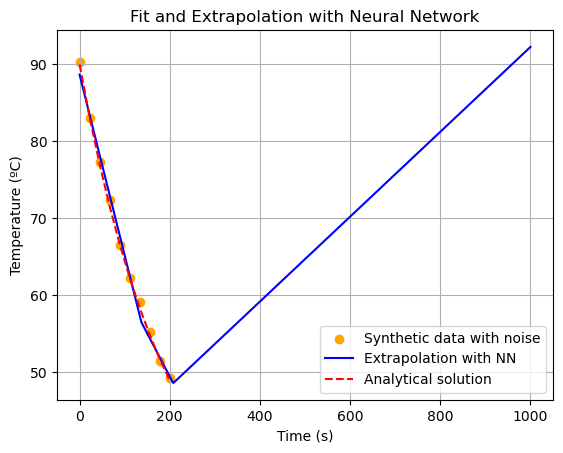

In [ ]:
# Converting the data to tensors
X_train = tf.convert_to_tensor(solution.t.reshape(-1, 1), dtype=tf.float32)
y_train = tf.convert_to_tensor(synthetic_data.reshape(-1, 1), dtype=tf.float32)

# Defining the neural network architecture
model = models.Sequential([
    layers.Input(shape=(1,)),
    layers.Dense(10, activation='relu'),
    layers.Dense(10, activation='relu'),
    layers.Dense(1)
])

# Compiling the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.007), loss='mse')

# Training the neural network
model.fit(X_train, y_train, epochs=800, verbose=True)

# Extrapolating the neural network
X_test = np.linspace(0, 200, 1000).reshape(-1, 1)

t_mean = X_train.numpy().mean()
t_std = X_train.numpy().std()
X_train_norm = (X_train - t_mean) / t_std
X_test_norm = (X_test - t_mean) / t_std

y_pred = model.predict(X_test_norm)

plt.scatter(solution.t, synthetic_data, label="Synthetic data with noise", color='orange')
plt.plot(X_test, y_pred, label="Extrapolation with NN", color='blue')
plt.plot(solution.t, T_analyt, '--', label="Analytical solution", color='red')

plt.xlabel("Time (s)")
plt.ylabel("Temperature (ºC)")
plt.legend()
plt.title("Fit and Extrapolation with Neural Network")
plt.grid(True)
plt.show()

PINN was constructed with 3 hidden layers (15 neurons each, ReLU activation) and 1 output layer; Training minimizes both the data loss (fit to synthetic data) and the physics loss (ODE residual).
After training, the model's predictions are plotted against the noisy data and the analytical solution.

Epoch [0/800], Loss: 4586.9336
Epoch [100/800], Loss: 62.8651
Epoch [200/800], Loss: 8.6209
Epoch [300/800], Loss: 0.9683
Epoch [400/800], Loss: 0.5762
Epoch [500/800], Loss: 0.5495
Epoch [600/800], Loss: 3.4552
Epoch [700/800], Loss: 2.8410


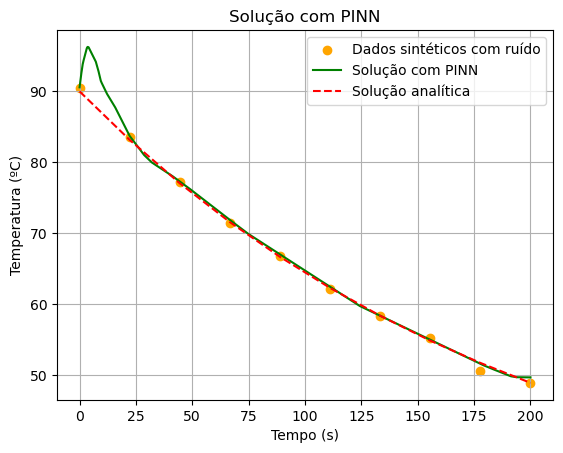

In [37]:
class PINN(tf.keras.Model):
    def __init__(self, r=0.005):
        super(PINN, self).__init__()
        self.dense1 = layers.Dense(64, activation='relu')
        self.dense2 = layers.Dense(64, activation='relu')
        self.dense3 = layers.Dense(64, activation='relu')
        self.dense4 = layers.Dense(1)
        self.r = r

    def call(self, t):
        t = self.dense1(t)
        t = self.dense2(t)
        t = self.dense3(t)
        t = self.dense4(t)
        return t

    def physics_loss(self, t, T):
        with tf.GradientTape() as tape:
            tape.watch(t)
            T_pred = self.call(t)
            dTdt = tape.gradient(T_pred, t) / t_std
            T_amb = 25
            loss = tf.reduce_mean(tf.square(dTdt - self.r * (T_amb - T_pred)))
            return loss

# Initializing the PINN model
model_pinn = PINN(r=0.005)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.007)

# Defining the collocation points for the physics loss
t_phys = tf.linspace(0.0, 200, 1000)[:, tf.newaxis]


# Training the PINN model
epochs = 800
for epoch in range(epochs):
    with tf.GradientTape() as tape:
        T_pred = model_pinn(X_train)
        loss_data = tf.reduce_mean(tf.square(T_pred - y_train))
        loss_phys = model_pinn.physics_loss(t_phys, model_pinn(t_phys))
        loss = loss_data + 10.0 * loss_phys
    grads = tape.gradient(loss, model_pinn.trainable_variables)
    optimizer.apply_gradients(zip(grads, model_pinn.trainable_variables))

    if epoch % 100 == 0:
        print(f"Epoch [{epoch}/{epochs}], Loss: {loss.numpy():.4f}")

T_pinn = model_pinn(X_test).numpy()

plt.scatter(solution.t, synthetic_data, label="Dados sintéticos com ruído", color='orange')
plt.plot(X_test, T_pinn, label="Solução com PINN", color='green')
plt.plot(solution.t, T_analyt, '--', label="Solução analítica", color='red')

plt.xlabel("Tempo (s)")
plt.ylabel("Temperatura (ºC)")
plt.legend()
plt.title("Solução com PINN")
plt.grid(True)
plt.show()

Epoch [0/800], Loss: 4582.1660, r: 0.006669
Epoch [100/800], Loss: 3.4106, r: 0.005479
Epoch [200/800], Loss: 0.6707, r: 0.004959
Epoch [300/800], Loss: 0.2757, r: 0.005011
Epoch [400/800], Loss: 0.1720, r: 0.005058
Epoch [500/800], Loss: 0.1142, r: 0.005080
Epoch [600/800], Loss: 0.0733, r: 0.005087
Epoch [700/800], Loss: 0.0462, r: 0.005089


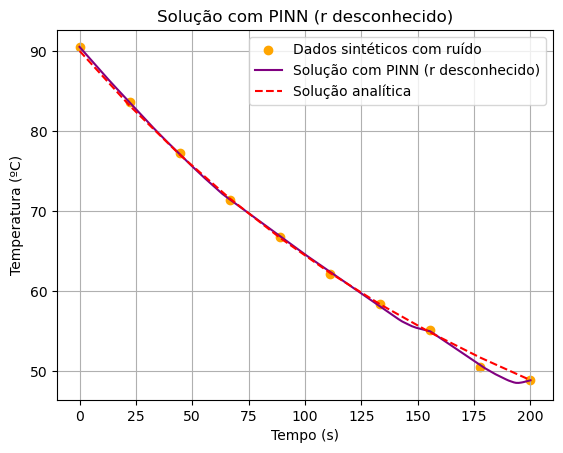

In [ ]:
t_phys_norm = (t_phys - t_mean) / t_std

class PINN_r_unknown(tf.keras.Model):
    def __init__(self):
        super(PINN_r_unknown, self).__init__()
        self.dense1 = layers.Dense(64, activation='relu')
        self.dense2 = layers.Dense(64, activation='relu')
        self.dense3 = layers.Dense(64, activation='relu')
        self.dense4 = layers.Dense(1)
        # Parâmetro livre, pode ser negativo, mas r será sempre positivo
        self.r_raw = self.add_weight(
            name='r_raw',
            shape=(),
            initializer=tf.constant_initializer(-5.0),
            trainable=True,
            dtype=tf.float32
        )
        
    @property
    def r(self):
        # Softplus garante r > 0
        return tf.nn.softplus(self.r_raw)
        
    def call(self, t):
        t = self.dense1(t)
        t = self.dense2(t)
        t = self.dense3(t)
        t = self.dense4(t)
        return t

    def physics_loss(self, t, T):
        with tf.GradientTape() as tape:
            tape.watch(t)
            T_pred = self.call(t)
        dTdt = tape.gradient(T_pred, t) / t_std
        T_amb = 25
        # Use self.r (sempre positivo)
        loss = tf.reduce_mean(tf.square(dTdt + self.r * (T_pred - T_amb)))
        return loss
    

# Inicializando e treinando a PINN
model_pinn_r_unknown = PINN_r_unknown()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.007)

# Defina os pontos de collocation para a physics loss (domínio físico)
t_phys = tf.linspace(0.0, 1000.0, 1000)[:, tf.newaxis]

# Treinando a PINN
epochs = 800
for epoch in range(epochs):
    with tf.GradientTape() as tape:
        T_pred = model_pinn_r_unknown(X_train_norm)
        loss_data = tf.reduce_mean(tf.square(T_pred - y_train))
        loss_phys = model_pinn_r_unknown.physics_loss(t_phys_norm, model_pinn_r_unknown(t_phys_norm))
        loss = loss_data + 2.0 * loss_phys
    grads = tape.gradient(loss, model_pinn_r_unknown.trainable_variables)
    optimizer.apply_gradients(zip(grads, model_pinn_r_unknown.trainable_variables))

    if epoch % 100 == 0:
        print(f"Epoch [{epoch}/{epochs}], Loss: {loss.numpy():.4f}, r: {model_pinn_r_unknown.r.numpy():.6f}")

T_pinn_r_unknown = model_pinn_r_unknown(X_test_norm).numpy()
plt.scatter(solution.t, synthetic_data, label="Dados sintéticos com ruído", color='orange')
plt.plot(X_test, T_pinn_r_unknown, label="Solução com PINN (r desconhecido)", color='purple')
plt.plot(solution.t, T_analyt, '--', label="Solução analítica", color='red')
plt.xlabel("Tempo (s)")
plt.ylabel("Temperatura (ºC)")
plt.legend()
plt.title("Solução com PINN (r desconhecido)")
plt.grid(True)
plt.show()
    